In [73]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

path = kagglehub.dataset_download("sidharth178/car-prices-dataset")

In [74]:
df = pd.read_csv(path + "/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [75]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [95]:
print("\nVérification des valeurs manquantes:")
print(df.isnull().sum())


Vérification des valeurs manquantes:
ID                     0
Price                  0
Levy                   0
Manufacturer           0
Model                  0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Engine volume          0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels           0
Doors                  0
Wheel               1250
Color                  0
Airbags                0
Age                    0
Turbo                  0
dtype: int64


In [76]:
print("Informations générales sur le dataset:")
print(f"Nombre total de véhicules: {len(df)}")
print(f"Nombre de constructeurs uniques: {df['Manufacturer'].nunique()}")
print(f"Nombre de modèles uniques: {df['Model'].nunique()}")
print(f"Années des véhicules: de {df['Prod. year'].min()} à {df['Prod. year'].max()}")

Informations générales sur le dataset:
Nombre total de véhicules: 19237
Nombre de constructeurs uniques: 65
Nombre de modèles uniques: 1590
Années des véhicules: de 1939 à 2020


In [98]:
def clean_prices_improved(df):
    df_clean = df.copy()
    
    # Filtres plus stricts sur les prix
    min_price = 1000  
    df_clean = df_clean[df_clean['Price'] >= min_price]
    
    # Traitement des kilométrages suspects
    current_year = 2024
    df_clean['is_new'] = (current_year - df_clean['Prod. year']) <= 1
    
    # Garder uniquement les 0 km pour les voitures neuves
    condition = ((df_clean['Mileage'] > 0) | 
                ((df_clean['Mileage'] == 0) & (df_clean['is_new'])))
    df_clean = df_clean[condition]
    
    # Supprimer la colonne temporaire
    df_clean = df_clean.drop('is_new', axis=1)
    
    # Utiliser un percentile plus restrictif pour les prix élevés
    Q1 = df_clean['Price'].quantile(0.10)
    Q3 = df_clean['Price'].quantile(0.90)
    IQR = Q3 - Q1
    prix_max = Q3 + 1.0 * IQR
    
    df_clean = df_clean[df_clean['Price'] <= prix_max]
    
    return df_clean

df = clean_prices_improved(df)
df = df.drop_duplicates()

In [82]:
df['Turbo'] = df['Engine volume'].str.contains('Turbo').astype(int)
df['Engine volume'] = df['Engine volume'].str.replace(' Turbo', '').astype(float)
df['Mileage'] = df['Mileage'].str.replace(' km', '').astype(float)
df['Leather interior'] = df['Leather interior'].map({'Yes': 1, 'No': 0})
df['Wheel'] = df['Wheel'].map({'Right wheel': 1, 'Left wheel': 0})

In [83]:
categorical_columns = ['Manufacturer', 'Model', 'Category', 'Fuel type', 
                      'Gear box type', 'Drive wheels', 'Color', 'Levy', 'Doors']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

In [84]:
numeric_columns = ['Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']
scaler = StandardScaler()
df_encoded[numeric_columns] = scaler.fit_transform(df_encoded[numeric_columns])

In [101]:
print("Véhicules avec 0 km:")
zero_mileage = df[df['Mileage'] == 0.0][['Manufacturer', 'Model', 'Prod. year', 'Price', 'Mileage']]
print(zero_mileage)

# Compter le nombre de véhicules avec 0 km par année
print("\nNombre de véhicules avec 0 km par année:")
print(zero_mileage['Prod. year'].value_counts().sort_index())

Véhicules avec 0 km:
Empty DataFrame
Columns: [Manufacturer, Model, Prod. year, Price, Mileage]
Index: []

Nombre de véhicules avec 0 km par année:
Series([], Name: count, dtype: int64)


In [91]:
print("\nDistribution des catégories de véhicules:")
print(df['Category'].value_counts())

# Distribution des types de carburant
print("\nDistribution des types de carburant:")
print(df['Fuel type'].value_counts())

# Age moyen par constructeur
print("\nAge moyen des véhicules par constructeur:")
current_year = 2024
df['Age'] = current_year - df['Prod. year']
print(df.groupby('Manufacturer')['Age'].mean().sort_values())

# Kilométrage moyen par constructeur
print("\nKilométrage moyen par constructeur:")
print(df.groupby('Manufacturer')['Mileage'].mean().sort_values())


Distribution des catégories de véhicules:
Category
Sedan          7103
Jeep           4273
Hatchback      2299
Minivan         585
Coupe           472
Universal       346
Microbus        258
Goods wagon     207
Pickup           38
Cabriolet        31
Limousine         6
Name: count, dtype: int64

Distribution des types de carburant:
Fuel type
Petrol            8212
Diesel            3546
Hybrid            2515
LPG                859
CNG                404
Plug-in Hybrid      81
Hydrogen             1
Name: count, dtype: int64

Age moyen des véhicules par constructeur:
Manufacturer
TESLA        6.000000
FERRARI      7.000000
BUICK        8.384615
HAVAL        9.000000
MASERATI    10.000000
              ...    
VAZ         27.868421
ZAZ         34.500000
GAZ         37.428571
UAZ         38.333333
MOSKVICH    58.500000
Name: Age, Length: 62, dtype: float64

Kilométrage moyen par constructeur:
Manufacturer
HAVAL           2.800000e+04
MASERATI        4.185500e+04
LANCIA          5.70000

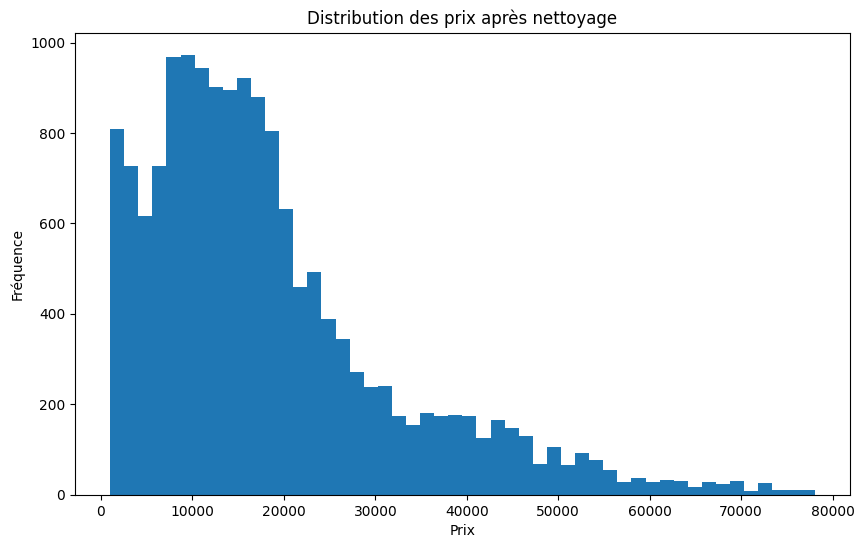

In [92]:
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=50)
plt.title('Distribution des prix après nettoyage')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.show()

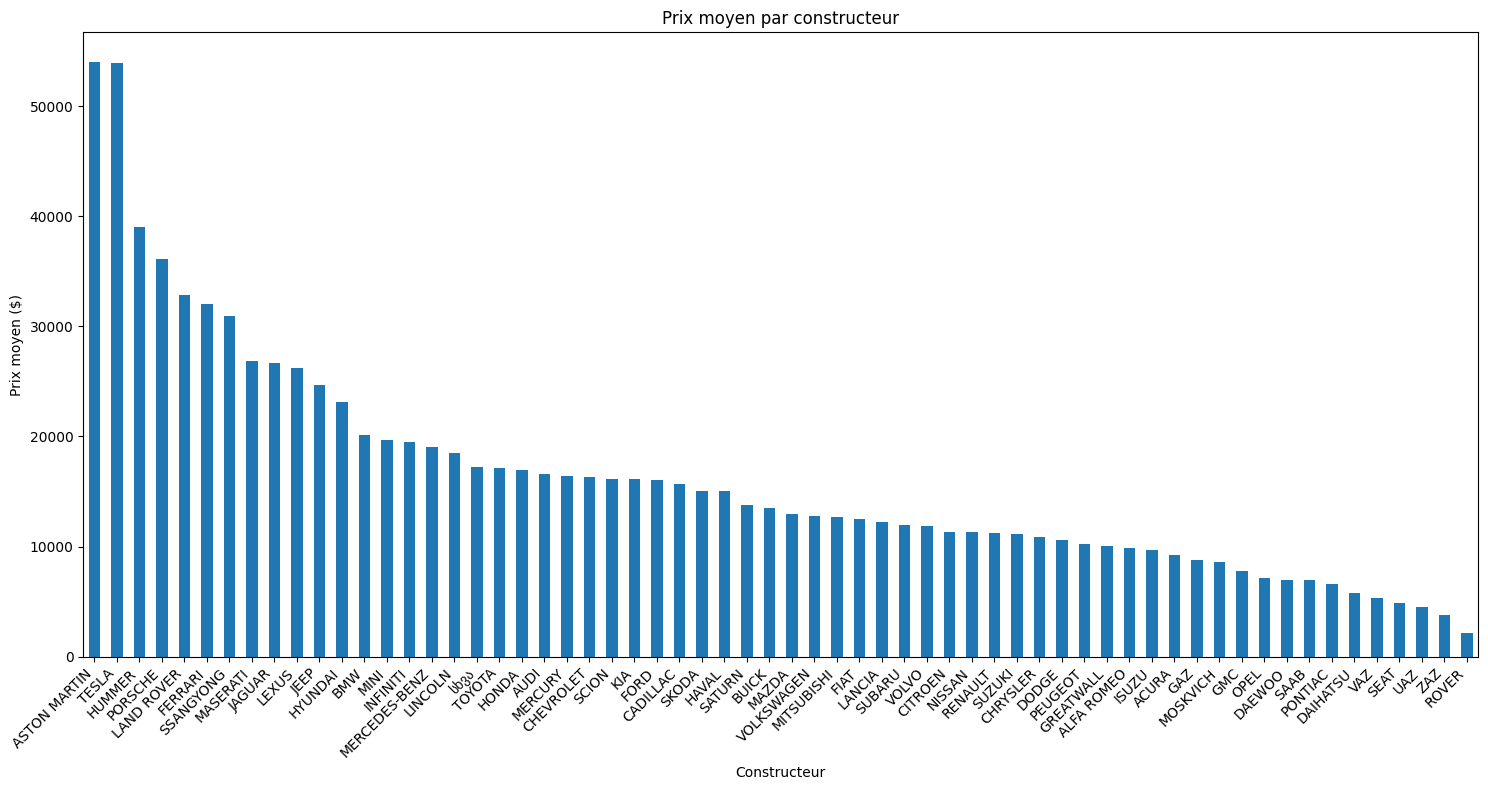

In [93]:
price_manufacturer = df.groupby('Manufacturer')['Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(15, 8))
price_manufacturer.plot(kind='bar')
plt.title('Prix moyen par constructeur')
plt.xlabel('Constructeur')
plt.ylabel('Prix moyen ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [85]:
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']

In [86]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [87]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

preprocessing_data = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
}

In [88]:
with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessing_data, f)

In [89]:
print("\nTop 5 des voitures les plus chères:")
print(df[['Price', 'Manufacturer', 'Model', 'Prod. year', 'Mileage']].nlargest(5, 'Price'))

print("\nTop 5 des voitures les moins chères:")
print(df[['Price', 'Manufacturer', 'Model', 'Prod. year', 'Mileage']].nsmallest(5, 'Price'))


Top 5 des voitures les plus chères:
       Price   Manufacturer               Model  Prod. year   Mileage
16481  78048           FORD            Explorer        2016   99742.0
90     77775  MERCEDES-BENZ           GL 63 AMG        2014  433811.0
1820   77775         TOYOTA  Land Cruiser Prado        2014  117000.0
8331   77775  MERCEDES-BENZ               E 400        2017    6200.0
16056  77775            BMW                  X5        2014  158000.0

Top 5 des voitures les moins chères:
       Price Manufacturer    Model  Prod. year  Mileage
3821    1000         FORD       KA        1999  13222.0
5617    1000        HONDA  Element        2012   5000.0
6179    1000         FIAT    Panda        1995   1300.0
12894   1000         FORD   Escort        1997  11000.0
13674   1000        MAZDA      323        1990   1111.0


In [90]:
print("\nDimensions des données après preprocessing:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")


Dimensions des données après preprocessing:
X_train: (9370, 2115)
X_val: (3124, 2115)
X_test: (3124, 2115)
